In [1]:
### Financial Econometrics II course SS 2018/2019 Prof. M. Rubaszek ###
## Block 1 ##


#########################################################################
### Modeling inflation rate in Czech Republic with ARMA and VAR models###
#########################################################################


# Data downloading from EUROSTAT #

library("eurostat")
data <- get_eurostat("prc_hicp_manr",
                     filters = list(geo="CZ", 
                                    coicop = "CP00",
                                    unit    ="RCH_A"))

# Some data manipulation #
library("zoo")

data <- zoo(data$values, order.by = data$time)

library(xts)

inflation <- as.xts(data)


Warning message:
"package 'eurostat' was built under R version 3.5.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



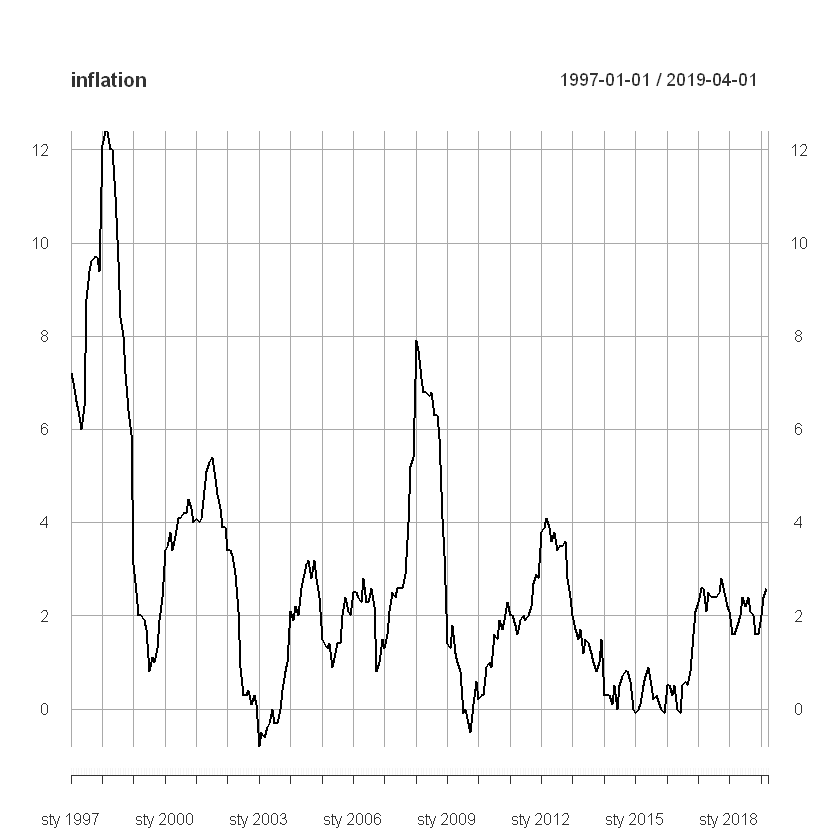

In [2]:
plot(inflation)

# There was a high inflation period in late 90's and around 2008 #
# 2003 and 2010 we observed deflation #

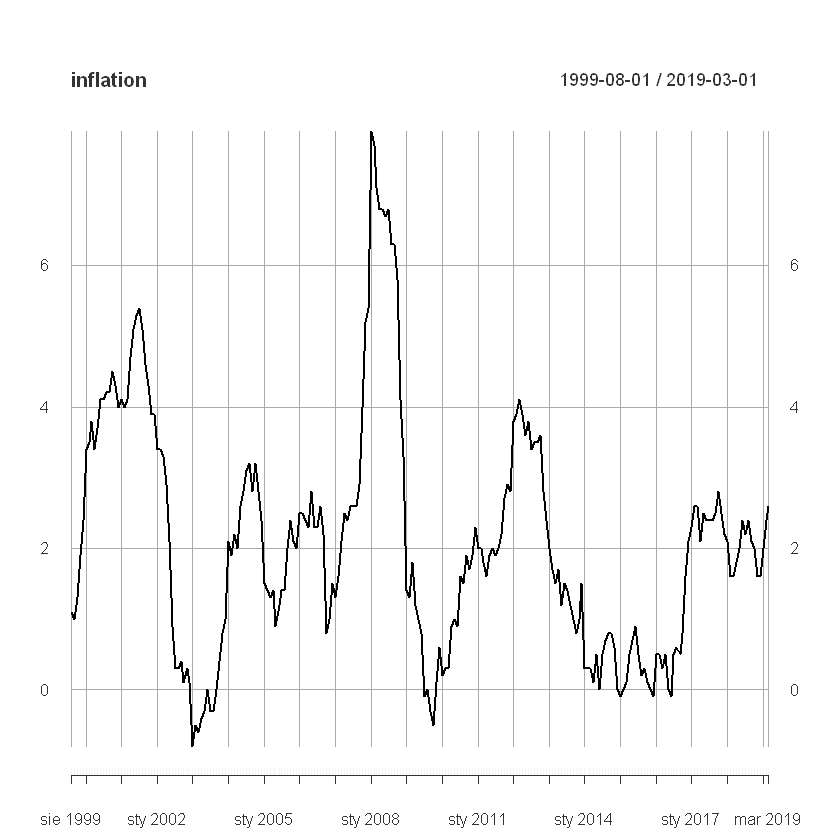

In [3]:
# For modeling purposes let's remove high inflation period #
inflation <- inflation[1:267,]
inflation <- inflation[index(inflation) > '1999-07-01']
plot(inflation)

In [4]:
# Let's test our time series for stationarity #

library(urca)

summary(ur.df(inflation, type = "none", selectlags = "AIC"))

# ADF test -> no enough evidence to reject the null about nonstationarity -> inflation is I(1)

summary(ur.pp(inflation, type = "Z-tau", model="constant"))
# We reject the null at 10 % significance but at 5% there is no enough evidence to do so

summary(ur.kpss(inflation, type = "mu"))
# At 10% signicficance there is no evidence to reject the null about stationarity -> inflation is I(0)

# Let's assume for further analysis inflation is stationary #

Warning message:
"package 'urca' was built under R version 3.5.2"


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67121 -0.19387  0.05501  0.30062  2.54243 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -0.01600    0.01084  -1.477 0.141023    
z.diff.lag  0.21996    0.06417   3.428 0.000719 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4451 on 232 degrees of freedom
Multiple R-squared:  0.05348,	Adjusted R-squared:  0.04532 
F-statistic: 6.555 on 2 and 232 DF,  p-value: 0.001702


Value of test-statistic is: -1.477 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



################################## 
# Phillips-Perron Unit Root Test # 
################################## 

Test regression with intercept 


Call:
lm(formula = y ~ y.l1)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.86229 -0.23886  0.01219  0.25203  2.61428 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.08261    0.04683   1.764    0.079 .  
y.l1         0.96354    0.01740  55.388   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4523 on 233 degrees of freedom
Multiple R-squared:  0.9294,	Adjusted R-squared:  0.9291 
F-statistic:  3068 on 1 and 233 DF,  p-value: < 2.2e-16


Value of test-statistic, type: Z-tau  is: -2.7479 

         aux. Z statistics
Z-tau-mu             2.238

Critical values for Z statistics: 
                     1pct      5pct   10pct
critical values -3.459557 -2.873902 -2.5733



####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 0.46 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Warning message:
"package 'forecast' was built under R version 3.5.2"

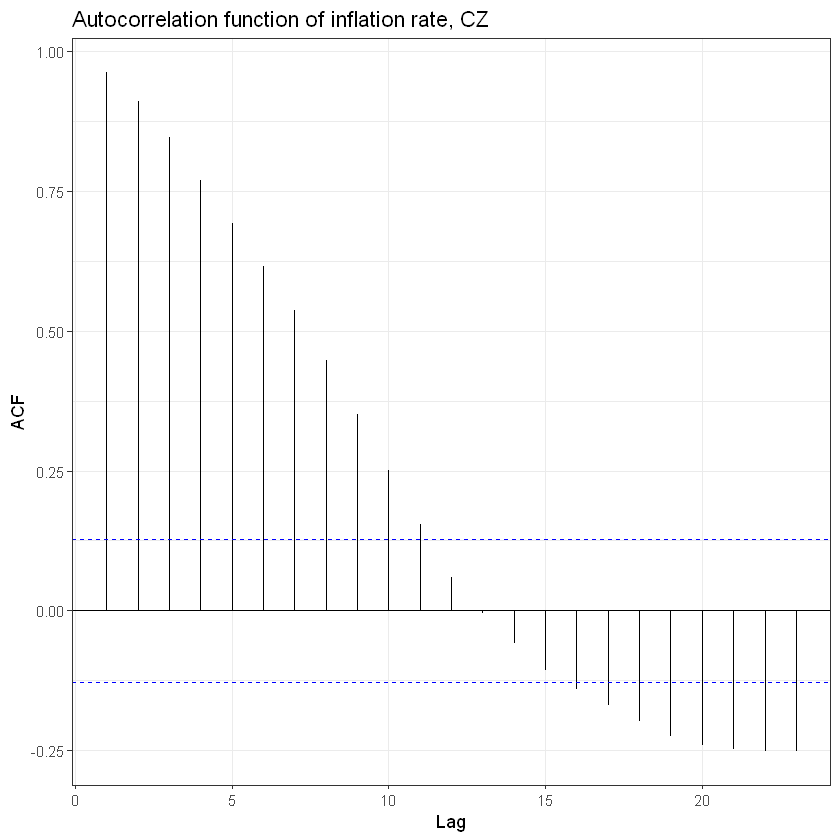

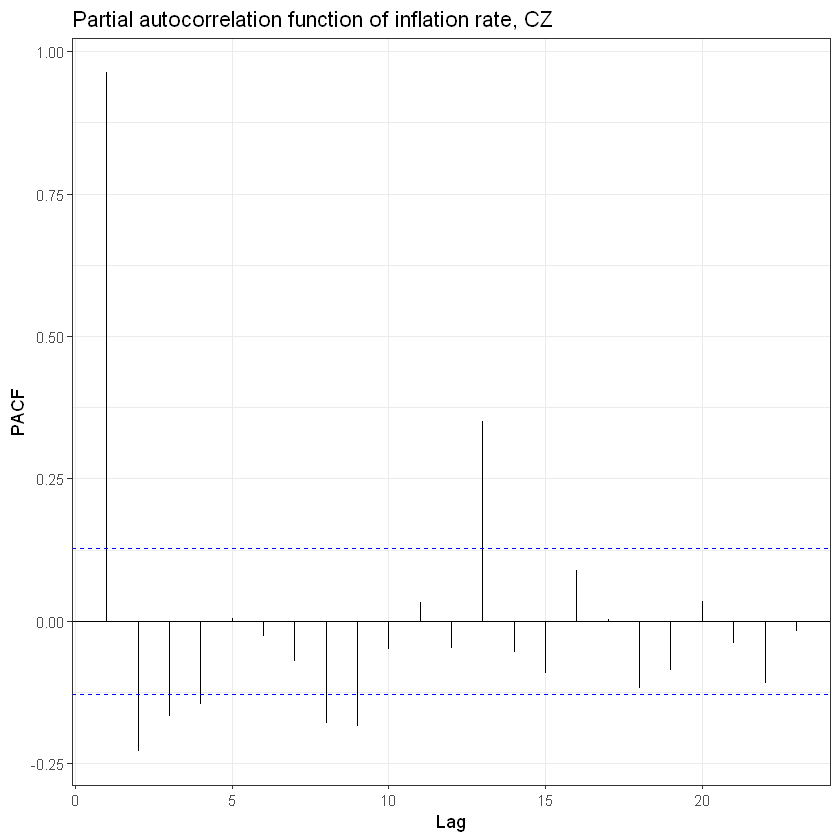

In [5]:
# We can now have a look at ACF and PACF function of inflation

library(ggplot2)
library(forecast)

# Why does ACF look as it looks like?

ggAcf(coredata(inflation))+
  theme_bw()+
  ggtitle("Autocorrelation function of inflation rate, CZ")

# Why is there a spike at 13th lag ( not at 12th as expected - base effect)?
ggPacf(coredata(inflation))+
  theme_bw()+
  ggtitle("Partial autocorrelation function of inflation rate, CZ")


In [6]:
# Let's go with ARMA models #

#Lag selection function (based on information criteria)

LagSel <- function(x, Pmax=3, Qmax=3, d=0, crit="BIC"){
  IC <- matrix(NA, Pmax+1, Qmax+1)
  for(p in 0:Pmax){
    if(p==Pmax){x0=x} else {x0 = x[-(1:(Pmax-p))]} 
    for(q in 0:Qmax){
      if(crit == "AIC"){ IC[p+1,q+1] <- AIC(Arima(x0,order=c(p,d,q)), k=2) }
      if(crit == "BIC"){ IC[p+1,q+1] <- AIC(Arima(x0,order=c(p,d,q)), k=log(length(x)-p)) }
      if(crit == "HQ"){  IC[p+1,q+1] <- AIC(Arima(x[- (1:(Pmax-p+1))],order=c(p,d,q)), k=2*log(log(length(x)-p))) }
    }}
  rownames(IC) <- paste('ar',0:Pmax, sep=""); colnames(IC) <- paste('ma',0:Qmax, sep="")
  return(IC)
}

LagSel(as.ts(coredata(inflation)), crit="BIC")
which.min(LagSel(as.ts(coredata(inflation)), crit="BIC")) #ARMA (2,1)

LagSel(as.ts(coredata(inflation)), crit="AIC")
which.min(LagSel(as.ts(coredata(inflation)), crit="AIC")) #ARMA (2,1)

LagSel(as.ts(coredata(inflation)), crit="HQ")
which.min(LagSel(as.ts(coredata(inflation)), crit="HQ")) #ARMA (2,1)

# Every criterion indicates ARMA(2,1) model

,ma0,ma1,ma2,ma3
ar0,919.4202,664.4996,548.0501,457.2771
ar1,310.5567,306.6336,306.8009,301.9470
ar2,303.6884,291.5878,297.0402,306.2578
ar3,301.6698,297.7262,315.4862,312.3361


[1] 7

,ma0,ma1,ma2,ma3
ar0,912.4925,654.1081,534.1948,439.9580
ar1,300.1780,292.7952,289.5029,281.1895
ar2,289.8671,274.3112,276.3083,282.0705
ar3,284.4146,277.0199,291.3289,284.7278


[1] 7

,ma0,ma1,ma2,ma3
ar0,912.3693,656.4914,538.4080,446.0211
ar1,302.2991,296.6033,295.3358,288.6456
ar2,295.0484,281.1588,284.5493,293.7690
ar3,290.9840,284.6578,281.2218,284.3803


[1] 7

In [7]:
# Now we can estimate ARMA (2,1) model

options(digits=3)
arma0 <- arima(as.ts(coredata(inflation)), order = c(2,0,1))  

summary(Arima(as.ts(coredata(inflation)), order = c(2,0,1)))

Series: as.ts(coredata(inflation)) 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
        ar1     ar2     ma1   mean
      1.888  -0.907  -0.804  2.060
s.e.  0.048   0.045   0.077  0.289

sigma^2 estimated as 0.181:  log likelihood=-133
AIC=275   AICc=275   BIC=292

Training set error measures:
                  ME  RMSE   MAE MPE MAPE  MASE    ACF1
Training set 0.00487 0.422 0.308 NaN  Inf 0.959 0.00855


In [8]:
## 3 different estimation methods ##


# Conditional sum of squares
arma.CSS    <- Arima(as.ts(coredata(inflation)), order = c(2, 0, 1), method = "CSS")

# Maximum likelihood 
arma.ML     <- Arima(as.ts(coredata(inflation)), order = c(2, 0, 1), method = "ML")

# Mixture of two methods desribed above
arma.CSS_ML <- Arima(as.ts(coredata(inflation)), order = c(2, 0, 1), method="CSS-ML")

ARMA.coef <- matrix(NA,3,4)
ARMA.coef[1,] <- arma.CSS_ML[["coef"]]
ARMA.coef[2,] <- arma.CSS[["coef"]]
ARMA.coef[3,] <- arma.ML[["coef"]]
rownames(ARMA.coef) <- c("CSS-ML","CSS","ML")
colnames(ARMA.coef) <- c("ar1", "ar2","ma1", "cons.")
ARMA.coef

# As we can see ML estimates differ from estimates obtained from CSS and CSS-ML
# We definitely don't want our MA coefficient to be 1 so we choose specification from CSS-ML

,ar1,ar2,ma1,cons.
CSS-ML,1.8885,-0.907,-0.804,2.06
CSS,1.8738,-0.894,-0.768,2.11
ML,0.0586,0.864,1.000,2.05


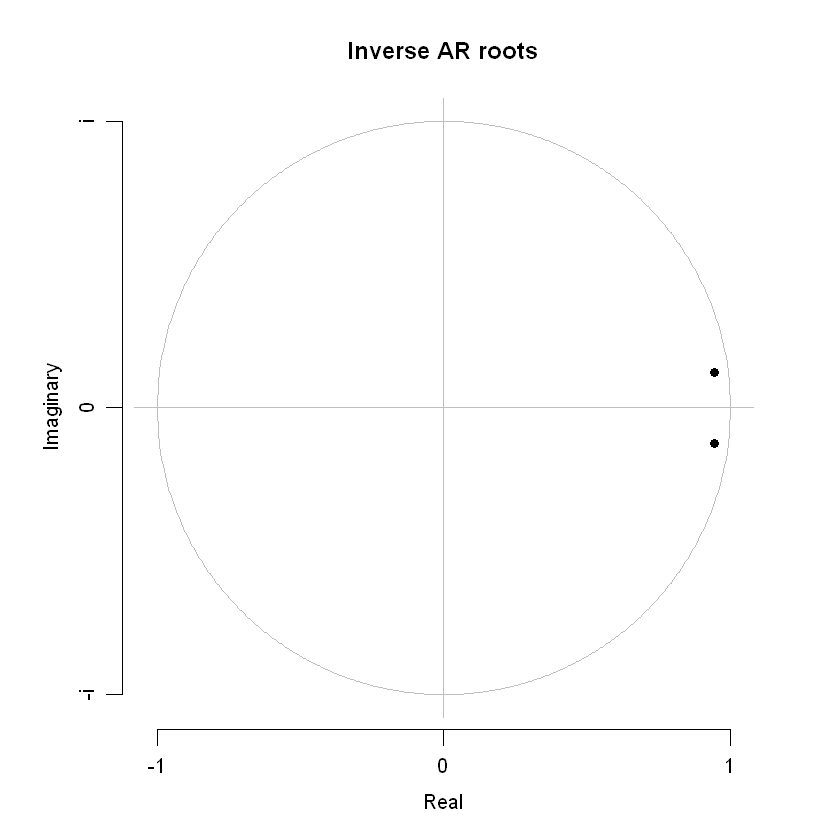

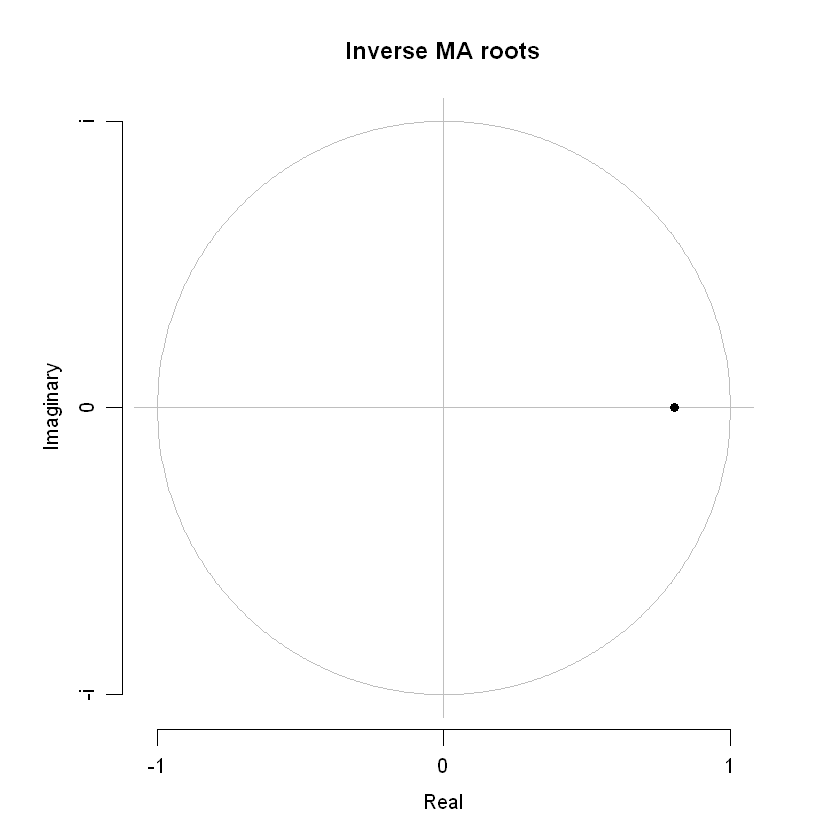

In [9]:
## Vizualisation of inverse AR and MA roots ##

## Function from R. Hyndman ##
## https://robjhyndman.com/hyndsight/arma-roots/ ##


# Compute AR roots
arroots <- function(object)
{
  if(!("Arima" %in% class(object)) & 
     !("ar" %in% class(object)))
    stop("object must be of class Arima or ar")
  if("Arima" %in% class(object))
    parvec <- object$model$phi
  else
    parvec <- object$ar
  if(length(parvec) > 0)
  {
    last.nonzero <- max(which(abs(parvec) > 1e-08))
    if (last.nonzero > 0)
      return(structure(list(
        roots=polyroot(c(1,-parvec[1:last.nonzero])),
        type="AR"), 
        class='armaroots'))
  }
  return(structure(list(roots=numeric(0), type="AR"),
                   class='armaroots'))
}

# Compute MA roots
maroots <- function(object)
{
  if(!("Arima" %in% class(object)))
    stop("object must be of class Arima")
  parvec <- object$model$theta
  if(length(parvec) > 0)
  {
    last.nonzero <- max(which(abs(parvec) > 1e-08))
    if (last.nonzero > 0)
      return(structure(list(
        roots=polyroot(c(1,parvec[1:last.nonzero])),
        type="MA"), 
        class='armaroots'))
  }
  return(structure(list(roots=numeric(0), type="MA"),
                   class='armaroots'))
}

plot.armaroots <- function(x, xlab="Real", ylab="Imaginary",
                           main=paste("Inverse roots of", x$type,
                                      "characteristic polynomial"),
                           ...)
{
  oldpar <- par(pty='s')
  on.exit(par(oldpar))
  plot(c(-1,1), c(-1,1), xlab=xlab, ylab=ylab,
       type="n", bty="n", xaxt="n", yaxt="n", main=main, ...)
  axis(1, at=c(-1,0,1), line=0.5, tck=-0.025)
  axis(2, at=c(-1,0,1), label=c("-i","0","i"), 
       line=0.5, tck=-0.025)
  circx <- seq(-1,1,l=501)
  circy <- sqrt(1-circx^2)
  lines(c(circx,circx), c(circy,-circy), col='gray')
  lines(c(-2,2), c(0,0), col='gray') 
  lines(c(0,0), c(-2,2), col='gray')
  if(length(x$roots) > 0) 
  {
    inside <- abs(x$roots) > 1
    points(1/x$roots[inside], pch=19, col='black')
    if(sum(!inside) > 0)
      points(1/x$roots[!inside], pch=19, col='red')
  }
}




plot(arroots(arma0),main="Inverse AR roots") # both AR roots are inside of unit circle
plot(maroots(arma0),main="Inverse MA roots") # Is it necessary for MA roots to lie inside of unit circle?

In [10]:
library(tseries)
jarque.bera.test(arma0$residuals)

# We reject the null about normality of the error term at every reasonable significance level #

Warning message:
"package 'tseries' was built under R version 3.5.2"


	Jarque Bera Test

data:  arma0$residuals
X-squared = 200, df = 2, p-value <2e-16


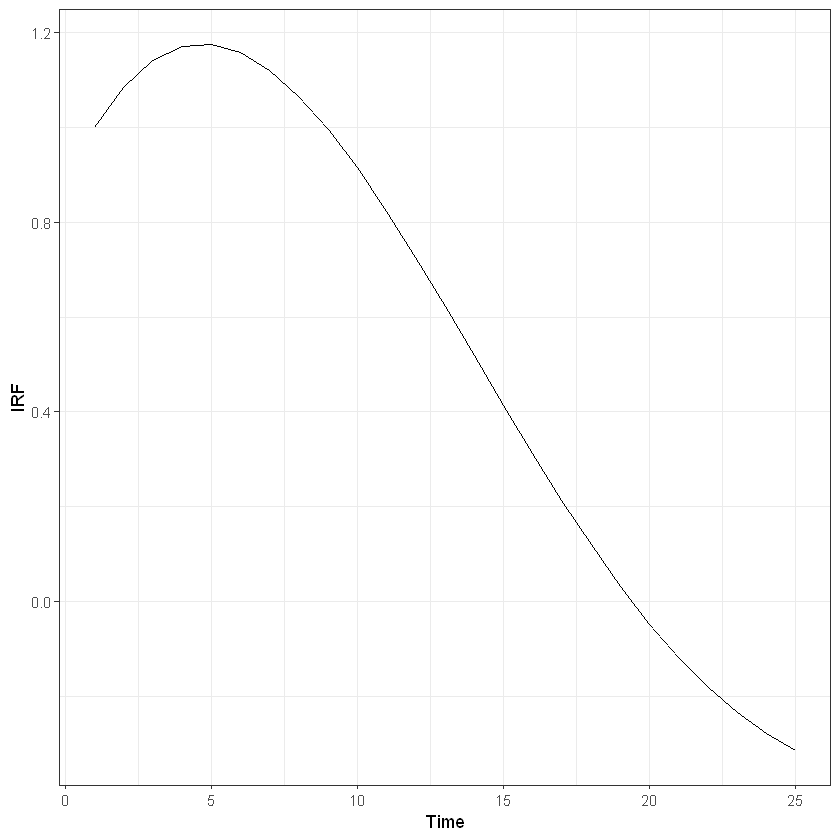

In [11]:
#Impulse reaction function

ma.coef <- arma0[["coef"]][3]
ar.coef <- arma0[["coef"]][c(1,2)]

IRF <- ARMAtoMA(ar = ar.coef,ma = ma.coef,24); IRF = c(1,IRF)
IRF<-as.ts(IRF)

autoplot(IRF)+
  theme_bw()

In [12]:
## VAR model ##
# Inflation in Czech Republic vs inflation in Euro Area

library(vars)

#Downloading the data from EUROSTAT

inf <- get_eurostat("prc_hicp_manr",
                     filters = list(geo=c("EA","CZ"),coicop="CP00",unit="RCH_A"))

infF <- subset(inf, geo == "EA")
infH <- subset(inf, geo == "CZ")

pF  <- na.omit(zoo(infF$values,order.by=infF$time))  # F stands for foreign
pF <- pF[index(pF) > '1999-07-01']

pH  <- na.omit(zoo(infH$values,order.by=infH$time)) # H for Home
pH <-  pH[index(pH) > '1999-07-01']

z <- merge(pF,pH,all=FALSE)

Warning message:
"package 'vars' was built under R version 3.5.3"Loading required package: MASS
Loading required package: strucchange
Warning message:
"package 'strucchange' was built under R version 3.5.3"Loading required package: sandwich
Loading required package: lmtest


In [13]:
# Lag selection #

VARselect(z, lag.max=6, type="const") # 4 or 2 
# 3 or 2 -> we prefer smaller models so 2 will be our choice

,1,2,3,4,5,6
AIC(n),-4.4554,-4.5557,-4.5716,-4.5815,-4.5651,-4.5629
HQ(n),-4.4193,-4.4954,-4.4872,-4.4730,-4.4325,-4.4061
SC(n),-4.3657,-4.4063,-4.3624,-4.3124,-4.2363,-4.1742
FPE(n),0.0116,0.0105,0.0103,0.0102,0.0104,0.0104


In [14]:
VARE <- VAR(z, p=2, type="const")
summary(VARE)


VAR Estimation Results:
Endogenous variables: pF, pH 
Deterministic variables: const 
Sample size: 234 
Log Likelihood: -120.167 
Roots of the characteristic polynomial:
0.941 0.936 0.332 0.0943
Call:
VAR(y = z, p = 2, type = "const")


Estimation results for equation pF: 
pF = pF.l1 + pH.l1 + pF.l2 + pH.l2 + const 

      Estimate Std. Error t value Pr(>|t|)    
pF.l1   1.0525     0.0706   14.90   <2e-16 ***
pH.l1   0.0814     0.0402    2.02    0.044 *  
pF.l2  -0.1037     0.0710   -1.46    0.146    
pH.l2  -0.0779     0.0400   -1.95    0.052 .  
const   0.0824     0.0357    2.30    0.022 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.253 on 229 degrees of freedom
Multiple R-Squared: 0.927,	Adjusted R-squared: 0.925 
F-statistic:  724 on 4 and 229 DF,  p-value: <2e-16 


Estimation results for equation pH: 
pH = pF.l1 + pH.l1 + pF.l2 + pH.l2 + const 

      Estimate Std. Error t value Pr(>|t|)    
pF.l1   0.5500     0.1184    4.65 

In [15]:
serial.test(VARE, lags.pt = 3, type="PT.adjusted") ## We reject the null about lack of serial correlation within model's residuals



	Portmanteau Test (adjusted)

data:  Residuals of VAR object VARE
Chi-squared = 20, df = 4, p-value = 8e-04

$serial

	Portmanteau Test (adjusted)

data:  Residuals of VAR object VARE
Chi-squared = 20, df = 4, p-value = 8e-04



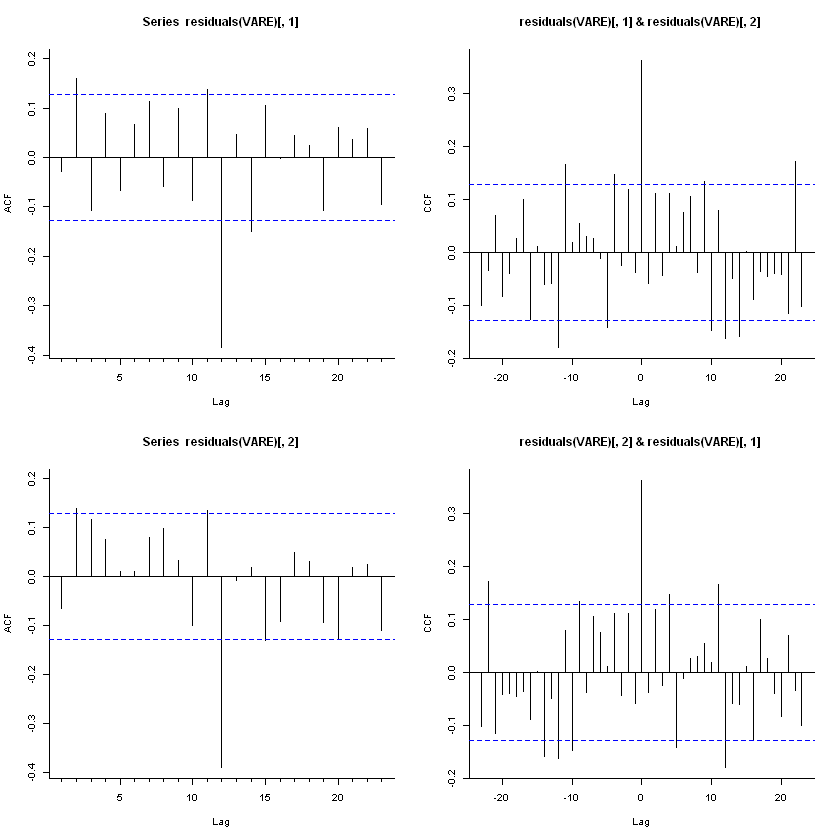

In [16]:
par(mfrow=c(2,2), cex = 0.5, bty="l")
Acf(residuals(VARE)[,1])
Ccf(residuals(VARE)[,1],residuals(VARE)[,2])

Acf(residuals(VARE)[,2])
Ccf(residuals(VARE)[,2],residuals(VARE)[,1]) # co 12 wypada istotne opoznienie  EFEKT BAZY -> dlatego lepiej modelowac infl m/m


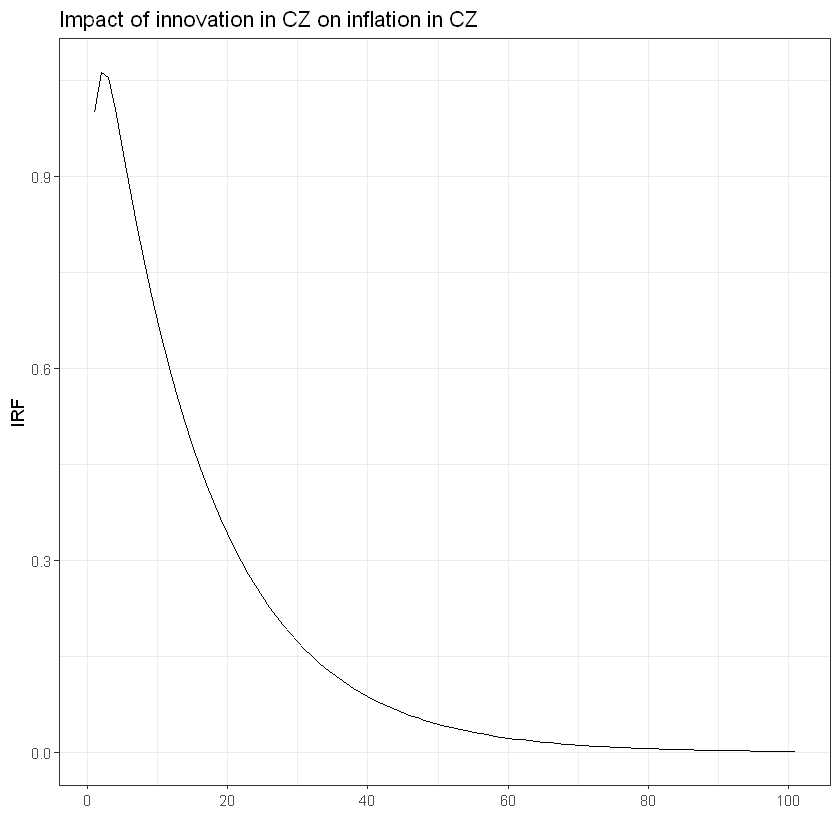

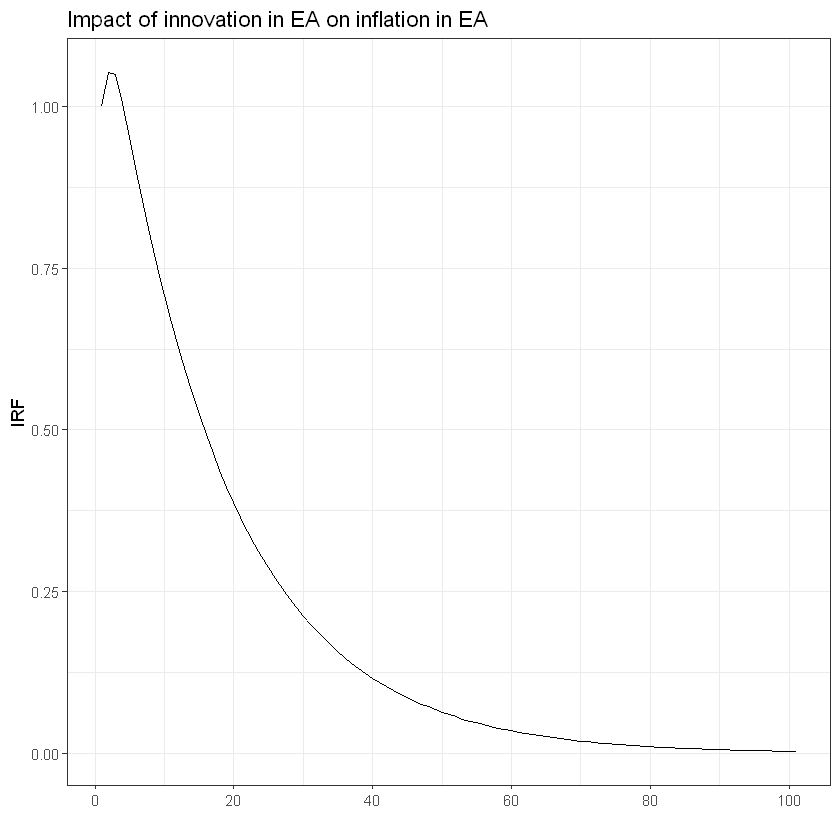

In [17]:
temp<-Phi(VARE,100) # In ordrer to present IRF function we have to find MA representation using Phi function


autoplot(as.ts(temp[2,2,]))+ # How innovation in Czech Republic affect inflation rate in CZ
  xlab("")+ylab("IRF")+theme_bw()+ggtitle("Impact of innovation in CZ on inflation in CZ")

autoplot(as.ts(temp[1,1,]))+  # How innovation in Euro Area affects inflation rate in EA
  xlab("")+ylab("IRF")+theme_bw()+ggtitle("Impact of innovation in EA on inflation in EA")


In [18]:
causality(VARE, cause="pF") #inlation in Euro Zone is Granger-cause for inflation in Czech Republic
causality(VARE, cause="pH") #inflation in Czech Republic isn't Granger-cause for inflation in Euro Zone

# So we can think about restrictions in order to estimate SVAR model
# This restriction is as following:
# In short-run there is no impact of innovation in Czech Republic on inflation in Euro Zone

$Granger

	Granger causality H0: pF do not Granger-cause pH

data:  VAR object VARE
F-Test = 10, df1 = 2, df2 = 500, p-value = 3e-05


$Instant

	H0: No instantaneous causality between: pF and pH

data:  VAR object VARE
Chi-squared = 30, df = 1, p-value = 2e-07



$Granger

	Granger causality H0: pH do not Granger-cause pF

data:  VAR object VARE
F-Test = 2, df1 = 2, df2 = 500, p-value = 0.1


$Instant

	H0: No instantaneous causality between: pH and pF

data:  VAR object VARE
Chi-squared = 30, df = 1, p-value = 2e-07



In [19]:
## Structural VAR model (SVAR)

bmat <- matrix(0,2,2)
bmat[lower.tri(bmat, diag=T)] <- NA
SVARE <- SVAR(VARE, Amat = NULL, Bmat = bmat)
SVARE
B <- SVARE$B 

Warning message in SVAR(VARE, Amat = NULL, Bmat = bmat):
"The B-model is just identified. No test possible."


SVAR Estimation Results:


Estimated B matrix:
      pF    pH
pF 0.253 0.000
pH 0.154 0.395

In [20]:
# structural IRF #

K    <- 48
SVMA <- Phi(SVARE, nstep=K)

# short run-impact matrix
SVMA[,,1]

0.253,0.000
0.154,0.395


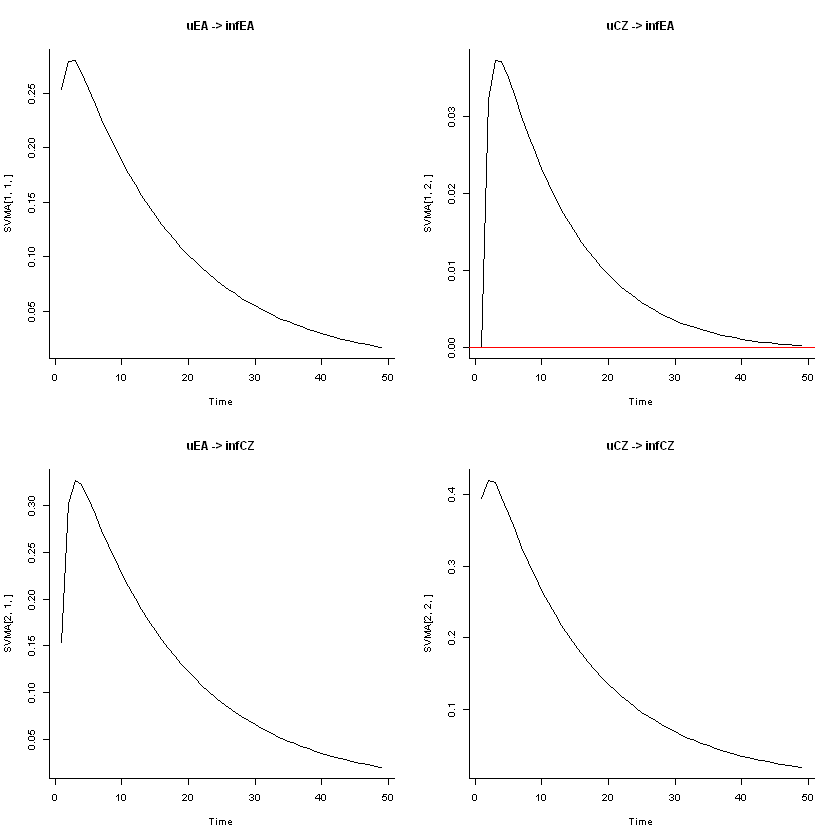

In [21]:
par(mfrow=c(2,2), cex = 0.5, bty="l")
plot.ts(SVMA[1,1,], main="uEA -> infEA"); abline(h=0, col = "red")
plot.ts(SVMA[1,2,], main="uCZ -> infEA"); abline(h=0, col = "red")
plot.ts(SVMA[2,1,], main="uEA -> infCZ"); abline(h=0, col = "red")
plot.ts(SVMA[2,2,], main="uCZ -> infCZ"); abline(h=0, col = "red")

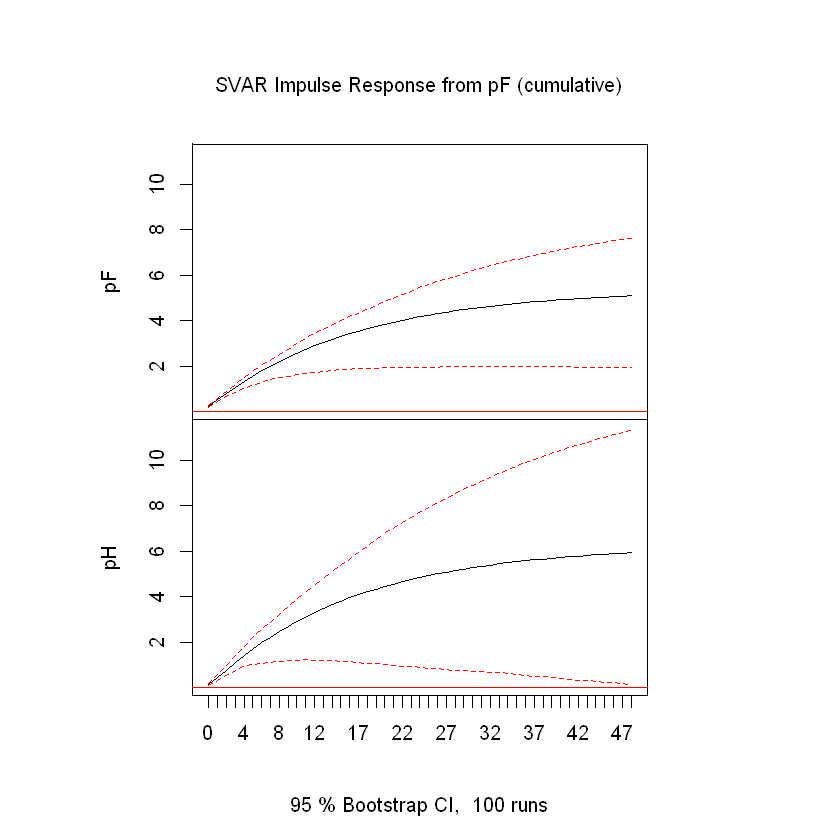

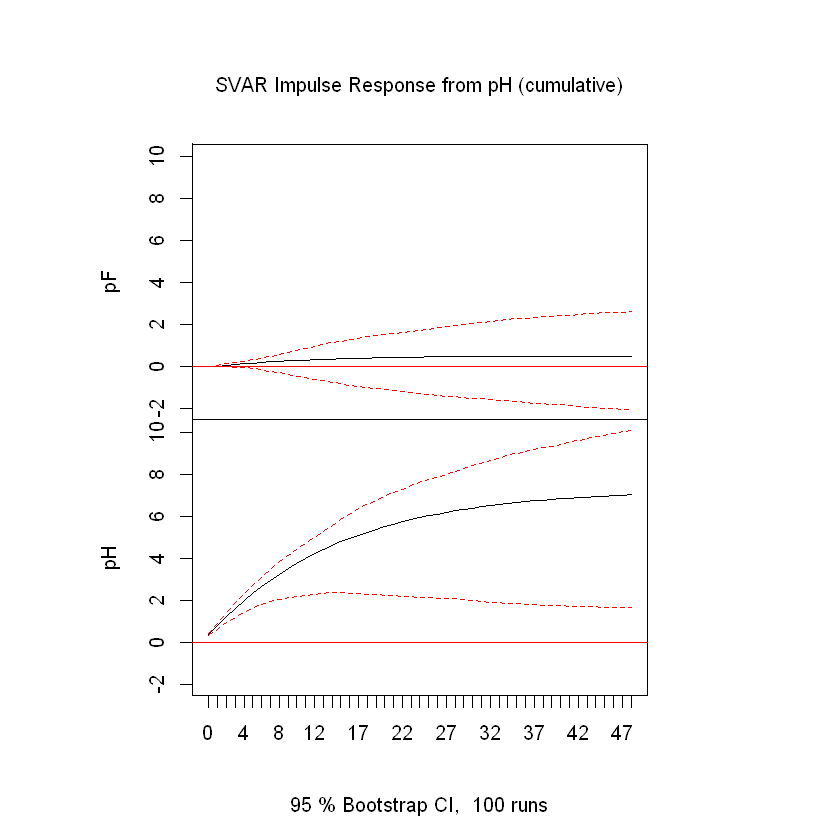

In [22]:
options(warn=-1)

SIRF <- irf(SVARE, n.ahead=K, cum = T, boot = T)
plot(SIRF)

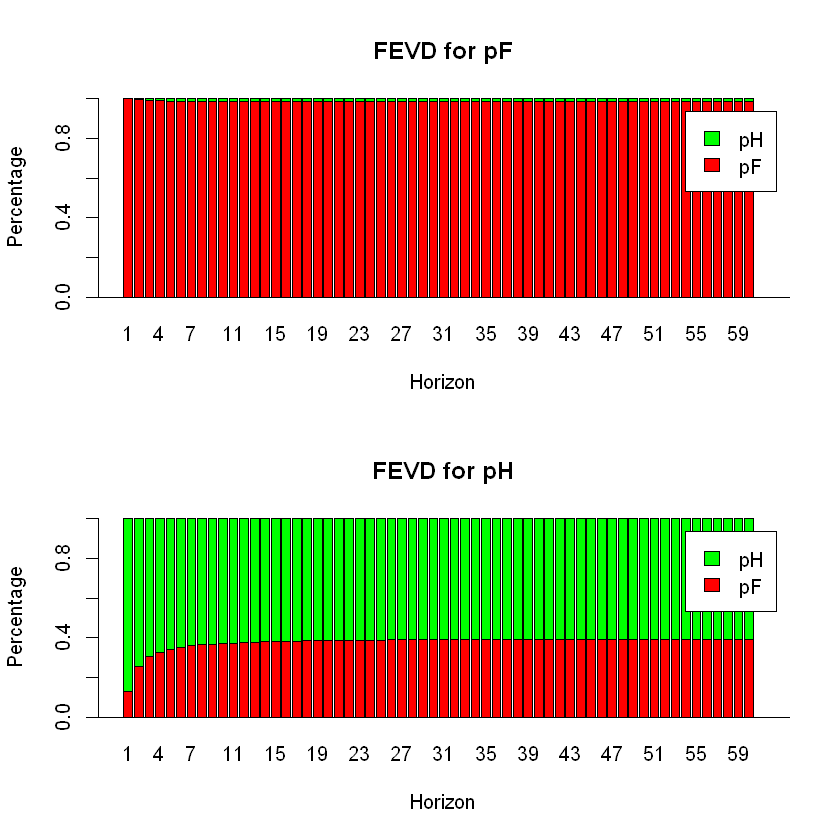

In [23]:
# Variance decomposition of forecast errors

plot(fevd(SVARE, n.ahead = 60), col = c("red", "green"))

#Almost whole variance of forecast errors of inflation in Euro Zone may be explained with shocks in Eurozone

# For inflation in Czech Republic it looks completely different:
# At the beginning about 85% of variance may be explauined wiht shocks in CZ
# In the furhter horizon about 30% of FV accounts for shocks in Euro zone

,pF,pH
pF,1.00e+00,3.52e-16
pH,3.52e-16,1.00e+00


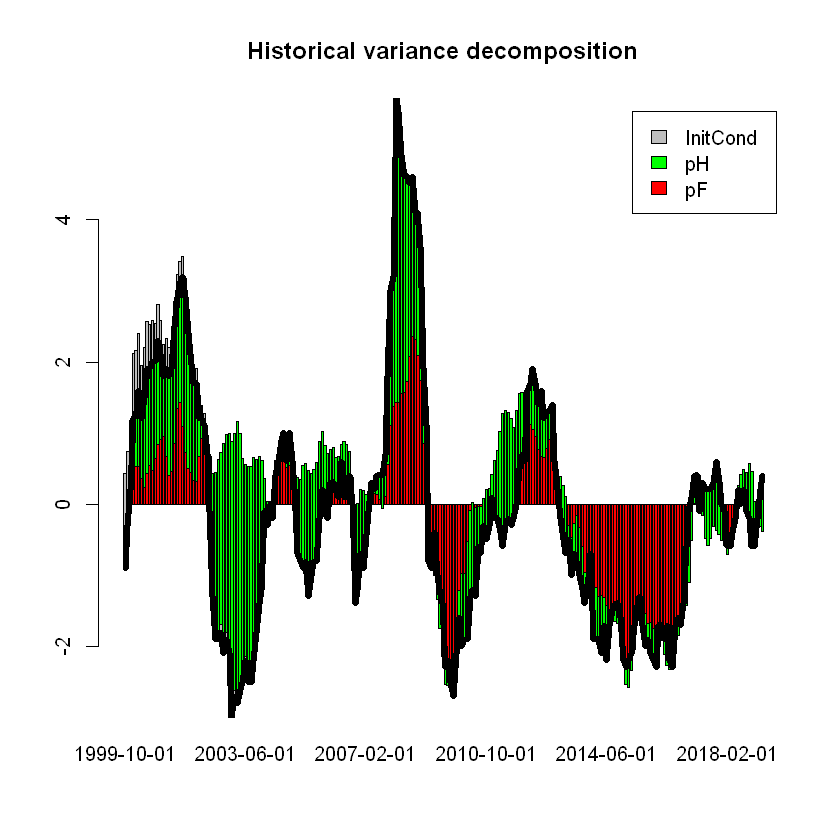

In [24]:
### Historical decomposition   ###

i      =2         # which variable [CZ or EA]

# a. Structural shocks
e <- residuals(VARE)
B <- SVARE$B
u <- t(solve(B)%*%t(e))
T <- dim(u)[1]
 cor(u) 

# b. IRFs
SVMA <- Phi(SVARE, nstep=T)
SIRF  = t(SVMA[i,,])    # IRF for variable i

# c. Historical decompositoion
HistDec             <- matrix(NA,T,2)
colnames(HistDec)   <- colnames(u)

for(t in 1:T){
  junk1 <- as.matrix(u[1:t,])
  junk2 <- as.matrix(SIRF[t:1,])
  HistDec[t,] <- colSums(junk1*junk2)
}

# the impact of initial conditions
InitCond <- tail(z[,i],T) - colSums(t(HistDec)) 
  mu       <- as.numeric(tail(InitCond,1))
InitCond <- InitCond - mu
HistDec  <- zoo(HistDec,order.by = index(InitCond))
HistDec  <- merge(HistDec, InitCond)


junk <- barplot(t(HistDec),main="Historical variance decomposition", legend=colnames(HistDec), xlab="", col = c("red","green", "grey"))
lines(x=junk, y=tail(z[,i],T)-mu, lwd=5)

# 1999 - 2008 shocks in Czech Republic were responsible for the most of fluctuations of the inflations rate in CZ

# Since economic crisis 2008 more and more of the fluctiuations were related to shocks in Euro Zone.


	Ljung-Box test

data:  Residuals from ARIMA(2,0,1) with non-zero mean
Q* = 20, df = 6, p-value = 0.02

Model df: 4.   Total lags used: 10




	Jarque Bera Test

data:  arma0$residuals
X-squared = 200, df = 2, p-value <2e-16


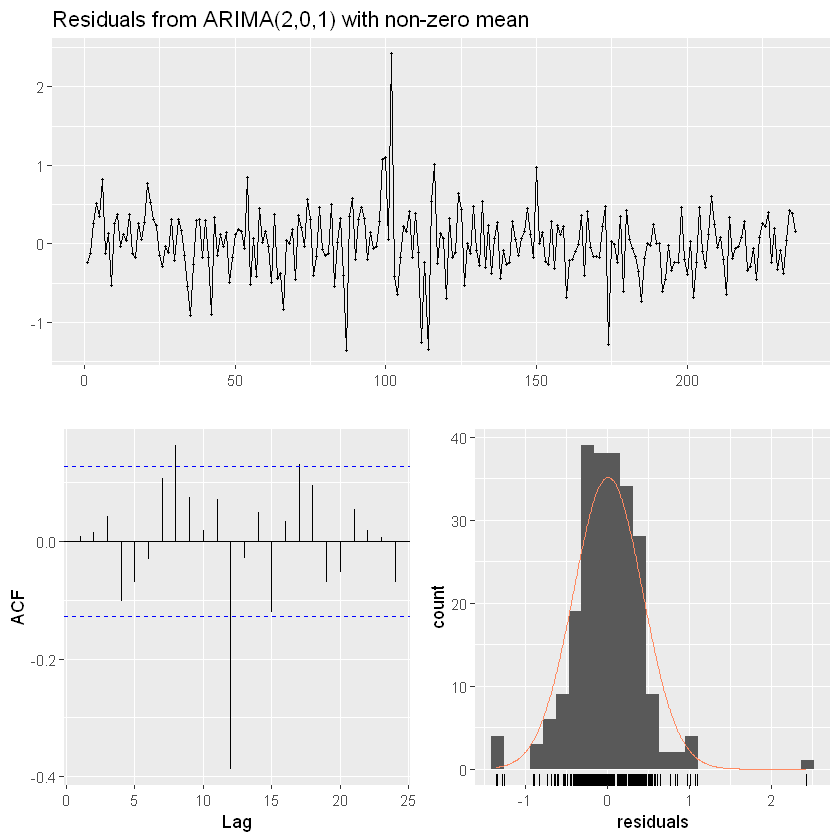

In [25]:
checkresiduals(arma0,test=FALSE) # AC in residuals claims forecast method can be improved

checkresiduals(arma0,plot=FALSE) # Small AC has though little impact even if significant

jarque.bera.test(arma0$residuals) # Non-gaussian residuals can be handled using bootstrap forecast intervals

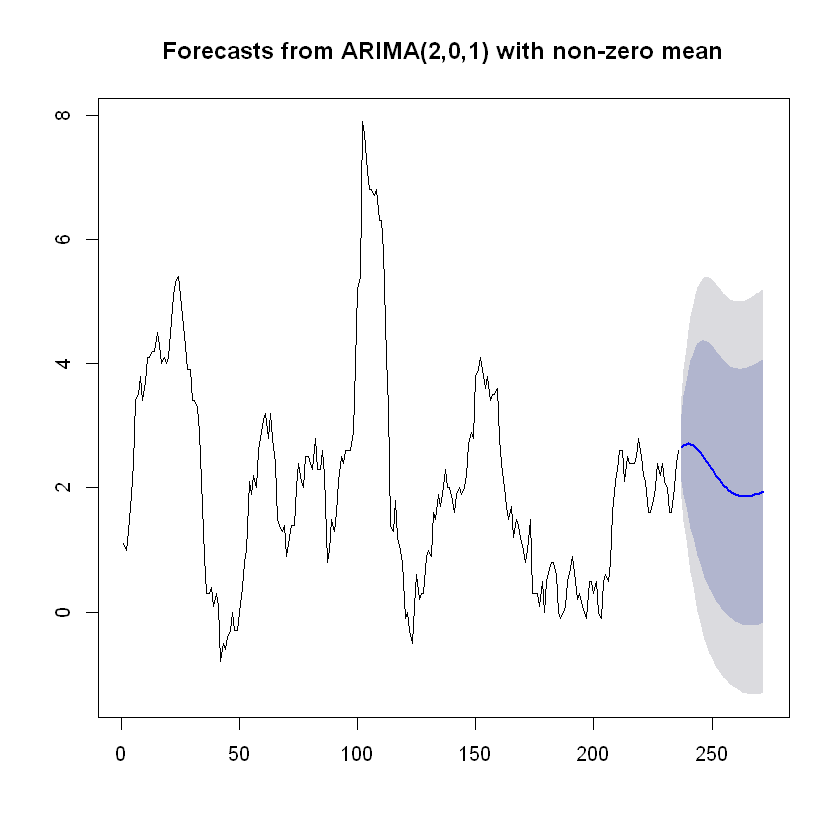

In [26]:
fcst <- forecast(arma0, h=36)

plot(fcst)

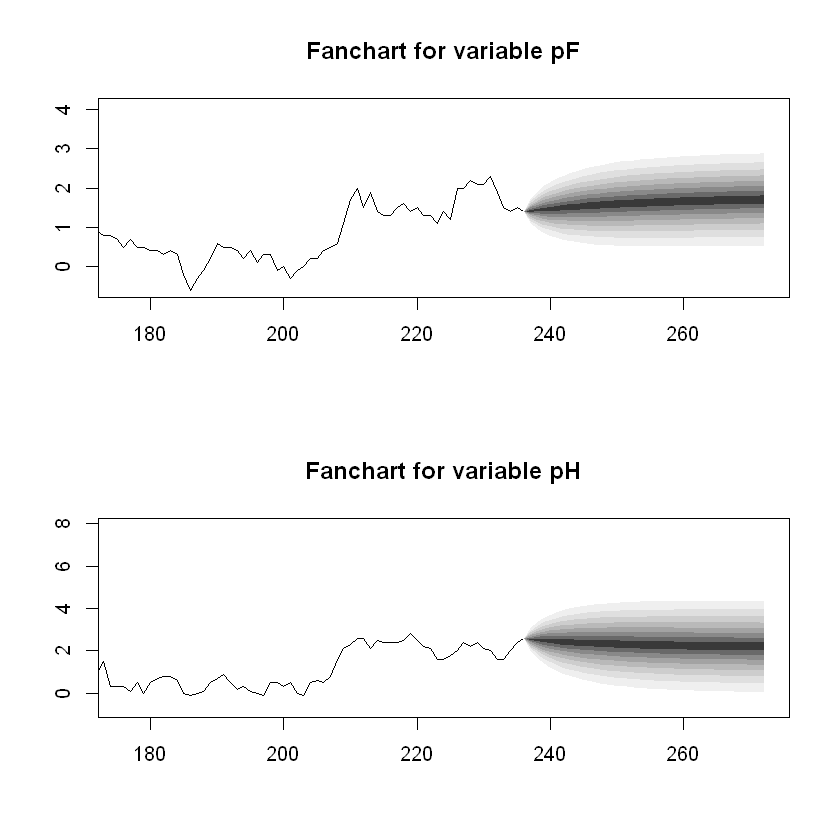

In [27]:
### Forecast ###

H   <- 36
T =dim(z)[1]
fct <- predict(VARE, n.ahead=H)

fanchart(fct, nc=1, xlim=c(T-60,T+H))
#

In [28]:
# Let's forecast annualized inflation rate from ARMA (2,1), VAR(2) against European Commission

## European Commission Forecasts available here:
# https://ec.europa.eu/info/business-economy-euro/economic-performance-and-forecasts/economic-performance-country/czechia/economic-forecast-czechia_en


require(lubridate)

datesf <- last(index(inflation))+months(1:36)

temp     <- zoo(fcst$mean,datesf) # ARMA forecasts
temp1 <- zoo(fct$fcst$pH[,1], datesf) # VAR forecasts

#Is mean appropriate for annualizing?

fARMA <- apply.yearly(temp,mean) #ARMA annualized forecasts
fVAR <- apply.yearly(temp1,mean) #VAR annualized forecasts
fEC <- c(NA, 2.4, 2.0, NA) # European Commission annualized forecasts

as.data.frame(cbind(fARMA,fVAR, fEC))

Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



,fARMA,fVAR,fEC
2019-12-01,2.66,2.45,NA
2020-12-01,2.23,2.31,2.4
2021-12-01,1.88,2.24,2.0
2022-03-01,1.93,2.22,NA
